# Initial character analysis

Just a very preliminary pass through the data, looking mainly for trends across the timeline. Few of the trends we initially notice are statistically significant.

That's ok -- null results can be interesting.

To start with we're going to go line by line through Patrick's character file, keeping only the lines that have docids attached. In each case we'll translate the docid into a date.


In [33]:
# first, some common imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import pearsonr

In [17]:
# actually read the data

ficmeta = pd.read_csv('../meta/filteredfictionmeta.tsv', sep = '\t', index_col = 'docid')
ficmeta = ficmeta[~ficmeta.index.duplicated(keep='first')]
charmeta = pd.read_csv('../meta/patchars.csv')
charmeta.head()

,docid,charid,charactername,gender,age,sequence,class,rankinbook,role,livelihood,comments,Unnamed: 11
0,mdp.39015013962207,Mrs.Dalloway,Clarissa Dalloway,f,52,NaN,middle class|rich,0.6,protagonist,marriage,NaN,NaN
1,mdp.39015013962207,Mr.Dalloway|Richard,Richard Dalloway,m,Middle-aged,NaN,rich|high official,0.6,love interest,NaN,NaN,NaN
2,mdp.39015013962207,Mr.Smith|Septimus,SeptimusSmith,m,adult,NaN,military|cultured,0.4,protagonist,NaN,disabled,NaN
3,mdp.39015013962207,William,Sir William Bradshaw,m,Middle-aged,NaN,rich|peer|professional,0.7,NaN,NaN,Self-made,NaN
4,mdp.39015013962207,Rezia|Mrs.Smith,Lucrezia Smith,f,adult,NaN,middle class,0.4,love interest,marriage,NaN,NaN


In [8]:
print(charmeta.shape)
print('We have ' + str(charmeta.shape[0]) + ' rows.')

(599, 12)
We have 599 rows.


Let's see how many rows we lose when we drop those without docids.

In [14]:
charmeta = charmeta.dropna(subset = ['docid'])
print('Now we have ' + str(charmeta.shape[0]) + ' rows.')

Now we have 550 rows.


In [18]:
def getdate(adocid):
    global ficmeta
    if adocid not in ficmeta.index:
        return 0
    else:
        return int(ficmeta.loc[adocid, 'inferreddate'])

In [19]:
newcol = charmeta.docid.map(getdate)
charmeta = charmeta.assign(date = newcol)

In [20]:
charmeta.head()

,docid,charid,charactername,gender,age,sequence,class,rankinbook,role,livelihood,comments,Unnamed: 11,date
0,mdp.39015013962207,Mrs.Dalloway,Clarissa Dalloway,f,52,NaN,middle class|rich,0.6,protagonist,marriage,NaN,NaN,1925
1,mdp.39015013962207,Mr.Dalloway|Richard,Richard Dalloway,m,Middle-aged,NaN,rich|high official,0.6,love interest,NaN,NaN,NaN,1925
2,mdp.39015013962207,Mr.Smith|Septimus,SeptimusSmith,m,adult,NaN,military|cultured,0.4,protagonist,NaN,disabled,NaN,1925
3,mdp.39015013962207,William,Sir William Bradshaw,m,Middle-aged,NaN,rich|peer|professional,0.7,NaN,NaN,Self-made,NaN,1925
4,mdp.39015013962207,Rezia|Mrs.Smith,Lucrezia Smith,f,adult,NaN,middle class,0.4,love interest,marriage,NaN,NaN,1925


## Initial guess about polarization

How widely are "rankinbooks" scattered? One way to measure is to take the standard deviation for each volume. We'll plot the standard deviations.

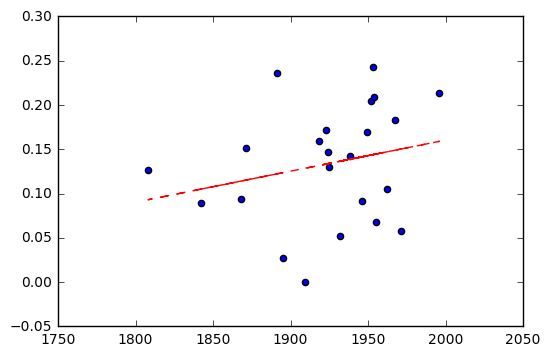

Pearson's R (0.23444905290923715, 0.2815817712282902)


In [66]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    deviation = np.std(group.rankinbook)
    x.append(thisdate)
    y.append(deviation)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
print("Pearson's R", pearsonr(x, y))   

Maybe a slight trend to have a wider spread later in the timeline, but it wasn't a statistically significant pattern.

When I print "Pearson's R" you're getting two numbers. The first is *r* itself, the correlation coefficient, and the second is the p-value, which should be below 0.05 for it to be a statistically significant trend. 0.28 isn't significant.

## Let's get a list of classes and of ages

Just to see what's actually in the dataset.


In [25]:
classlist = Counter()

for c in charmeta['class']:
    classes = c.split('|')
    for aclass in classes:
        classlist[aclass] += 1

for name, count in classlist.items():
    print(name, count)
        
    

performer 4
artist 4
banker 3
military 57
high officla 1
professional 70
domestic servant 1
peer 71
merchant 1
criminal 9
manager 1
farmer 20
landed gentry 26
classless 5
rich 111
high official 54
poor 41
artisan 2
landlord 2
clergy 15
wealthy 1
homeless 17
orphan 1
middle class 176
cultured 45
upper class 11
domestic help  18
proprietor 18
cultured  1
domestic help 8
disabled 8
slave 7
sex worker 6
working class 38
supernatural being 19
student 30


In [43]:
# list of ages

agelist = Counter()

for a in charmeta['age']:
    agelist[a] += 1

for name, count in agelist.items():
    print(name, count)
        

nan 26
young adult 58
elderly|immoral 1
elderly 40
immortal 14
52 1
Middle-aged 227
elderly|immortal 1
adult 199
child 32


## Let's check some basic hypotheses. 

We would certainly expect landed gentry to decline, for instance.

In each of the cells below, I measure the frequency of a given tag (or set of tags) relative to the total number of tags in a volume.

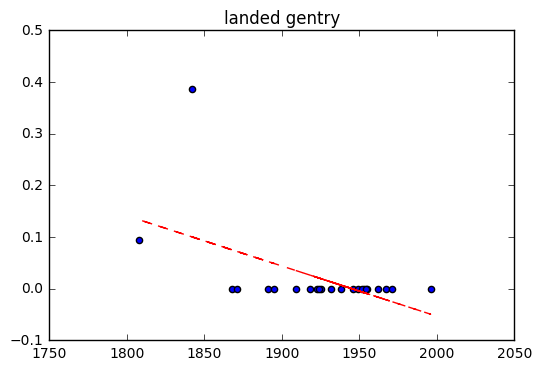

(-0.52922373607039774, 0.0094114368056855517)


In [76]:
# To start with, the landed gentry.

x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    uppertags = 0
    
    for c in group['class']:
        classes = c.split('|')
        for aclass in classes:
            totaltags += 1
            if aclass == 'landed gentry':
                uppertags += 1
    
    x.append(thisdate)
    y.append(uppertags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('landed gentry')
plt.show()
print(pearsonr(x, y)) 

Well, yes that's a statistically significant trend, but not a surprising one.

What about the working class?

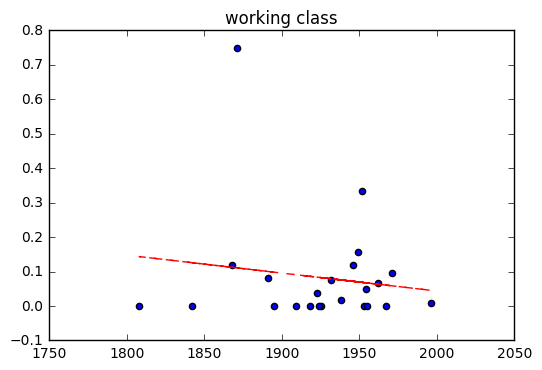

(-0.1410562528135072, 0.52088662341051872)


In [77]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    workingtags = 0
    
    for c in group['class']:
        classes = c.split('|')
        for aclass in classes:
            totaltags += 1
            if aclass == 'working class':
                workingtags += 1
    
    x.append(thisdate)
    y.append(workingtags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('working class')
plt.show()
print(pearsonr(x, y)) 

No pattern evident yet.

What about the middle class?

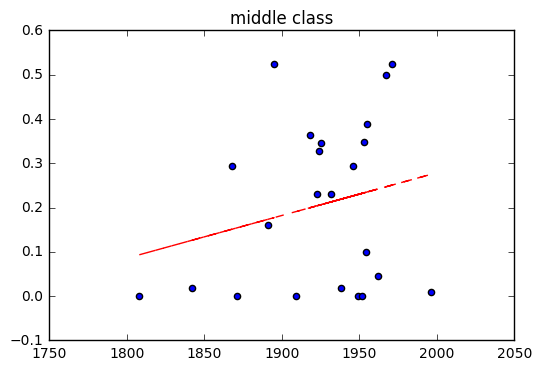

(0.22909278747279377, 0.29303531188494719)


In [78]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    middletags = 0
    
    for c in group['class']:
        classes = c.split('|')
        for aclass in classes:
            totaltags += 1
            if aclass == 'middle class':
                middletags += 1
    
    x.append(thisdate)
    y.append(middletags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('middle class')
plt.show()
print(pearsonr(x, y)) 

No statistically significant linear pattern, though there might be a peak 1900-1950; need more evidence.

What if we look at broadly defined upper and lower classes?

## Upper classes collectively

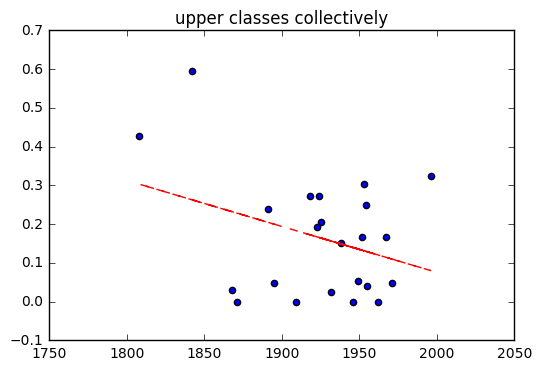

(-0.33748532843911139, 0.1152852275560477)


In [79]:
upper = {'rich', 'landed gentry', 'upper class', 'peer', 'wealthy', 'high official'}
lower = {'poor', 'working class', 'domestic help', 'slave', 'sex worker', 'criminal', 'homeless'}

x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    uppertags = 0
    
    for c in group['class']:
        classes = c.split('|')
        doneyet = False
        for aclass in classes:
            totaltags += 1
            if aclass in upper and not doneyet:
                uppertags += 1
                doneyet = True
    
    x.append(thisdate)
    y.append(uppertags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('upper classes collectively')
plt.show()
print(pearsonr(x, y)) 

Maybe almost a trend? But no dice. Maybe with more evidence from the late 18c this would become plain.

## Lower classes collectively

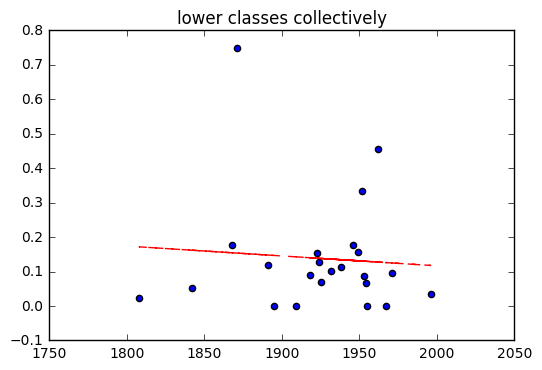

(-0.074960357794863403, 0.73391067130376109)


In [80]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    lowertags = 0
    
    for c in group['class']:
        classes = c.split('|')
        doneyet = False
        for aclass in classes:
            totaltags += 1
            if aclass in lower and not doneyet:
                lowertags += 1
                doneyet = True
    
    x.append(thisdate)
    y.append(lowertags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('lower classes collectively')
plt.show()
print(pearsonr(x, y)) 

pretty definitely no significance to that

## ages

What about the average age of characters, if we make it just sort of an arithmetic mean between child = 1, young adult = 2, adult = 3, middle-aged = 4, elderly = 5?

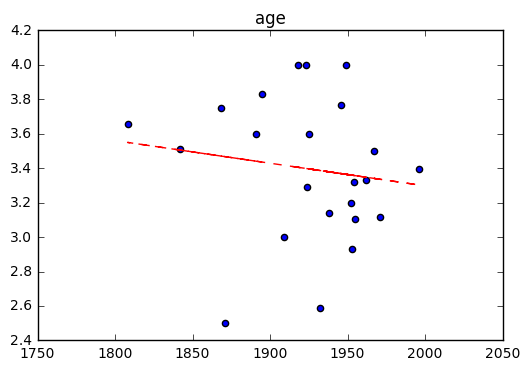

(-0.14057544617959516, 0.52232283693959203)


In [82]:
x = []
y = []

allages = []
allclasses = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    ages = []
    theseclasses = []
    if len(group['age']) != len(group['class']):
        print(len(group['age']), len(group['class']))
        
    for a in group['age']:
        if a == 'child':
            ages.append(1)
        elif a == 'young adult':
            ages.append(2)
        elif a == 'adult':
            ages.append(3)
        elif a == 'Middle-aged':
            ages.append(4)
        elif a == 'elderly':
            ages.append(5)
        else:
            ages.append(3)
    
    for c in group['class']:
        classes = c.split('|')
        netclass = 0
        for aclass in classes:
            if aclass in upper:
                netclass += 1
            elif aclass in lower:
                netclass -=1
            
        theseclasses.append(netclass)   

    x.append(thisdate)
    y.append(np.mean(ages))
    allages.extend(ages)
    allclasses.extend(theseclasses)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('age')
plt.show()
print(pearsonr(x, y)) 

## What about correlation between age and class?

Like, character by character, are old people more likely to be high status?

The answer is pretty clearly no.

In [63]:
pearsonr(allages, allclasses)

(0.035514153587271474, 0.41765720788971239)

## Conclusions so far

Not a lot of dramatic patterns!! Actually, this could be interesting, in the manner of a dog that didn't bark during the robbery. It's interesting that the class balance and degree of polarization seem to be pretty constant, or at least not changing in a linear fashion across time.

But we'll need more data to be certain even about that. I need to pull my weight in the data gathering.

I'm also still planning to do more with the language *describing* characters.